<a href="https://colab.research.google.com/github/iris-kurapaty/CodingPractice/blob/main/Step7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
pwd

'/content'

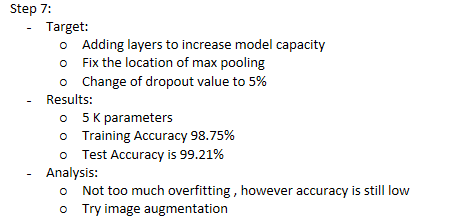

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 191159726.54it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7375529.34it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 146669170.50it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22842360.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


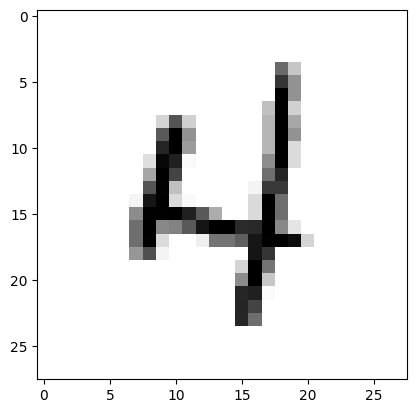

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_set = train_data.train_data
train_set = train_data.transform(train_set.numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train_set))
print(' - max:', torch.max(train_set))
print(' - mean:', torch.mean(train_set))
print(' - std:', torch.std(train_set))
print(' - var:', torch.var(train_set))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


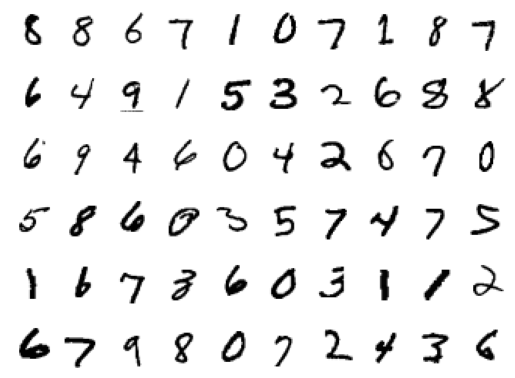

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [8]:
from model import Net7

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary(Net7, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12            [-1, 8, 10, 10]             576
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-1, 8,

# Training and Testing


In [10]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

# Let's Train and test our model

In [11]:
model =  Net7().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


Loss=0.13496780395507812 Batch_id=468 Accuracy=76.60: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]



Test set: Average loss: 0.1478, Accuracy: 9601/10000 (96.01%)

EPOCH: 1


Loss=0.16991685330867767 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0643, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.10031501203775406 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]



Test set: Average loss: 0.0552, Accuracy: 9839/10000 (98.39%)

EPOCH: 3


Loss=0.10359013825654984 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0441, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.0550692118704319 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0433, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


Loss=0.05572643503546715 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0430, Accuracy: 9874/10000 (98.74%)

EPOCH: 6


Loss=0.008553309366106987 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]



Test set: Average loss: 0.0410, Accuracy: 9878/10000 (98.78%)

EPOCH: 7


Loss=0.04278641566634178 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]



Test set: Average loss: 0.0412, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Loss=0.010846770368516445 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]



Test set: Average loss: 0.0326, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.0431654118001461 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0328, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.09159260243177414 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.014865480363368988 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.03356858715415001 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]



Test set: Average loss: 0.0399, Accuracy: 9873/10000 (98.73%)

EPOCH: 13


Loss=0.016692671924829483 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0325, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.06689245253801346 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]



Test set: Average loss: 0.0278, Accuracy: 9922/10000 (99.22%)



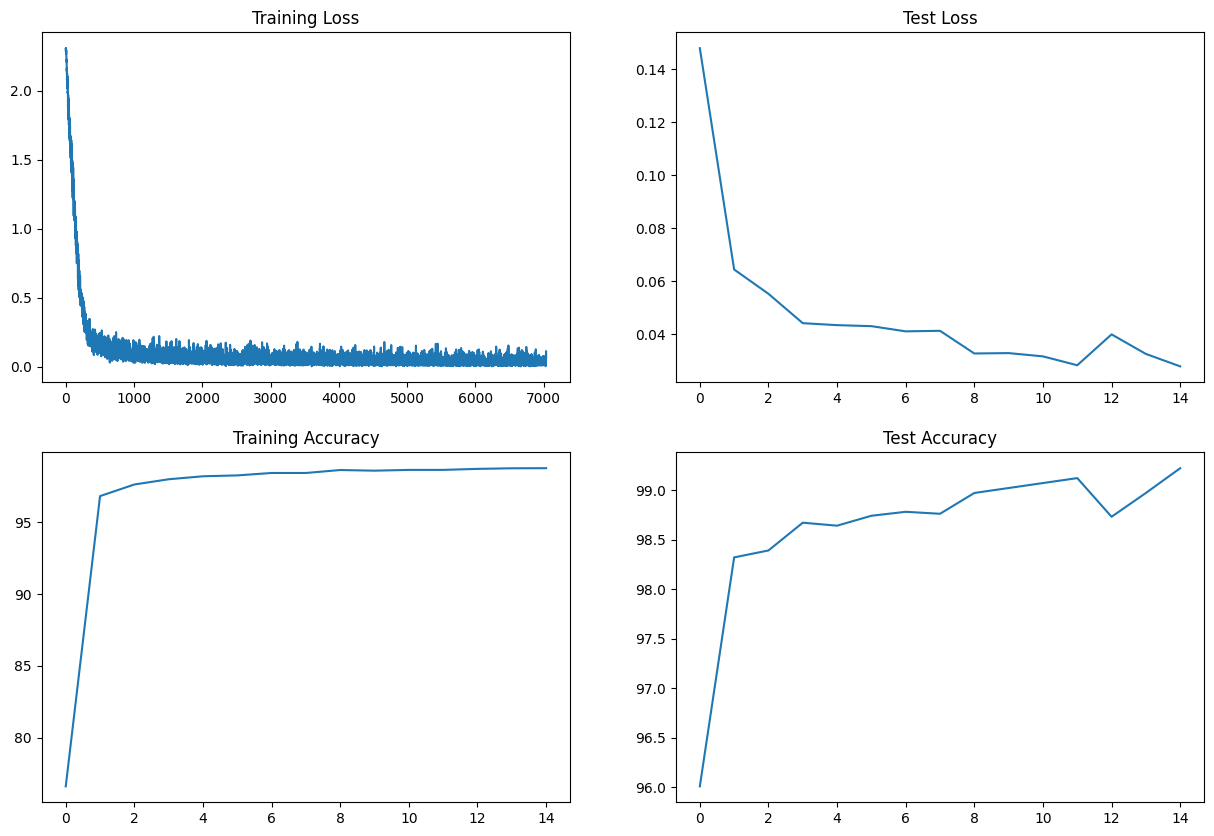

In [12]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)